In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
    }
plt.rcParams.update(tex_fonts)

In [18]:
# read in data
df_PM10 = pd.read_csv('../air_weather_data/PM10_all_stations_cleaned.csv')
df_PM10['date'] = pd.to_datetime(df_PM10['date'], format = '%Y-%m-%d %H:%M') # change time column to pandas datetime
df_PM10 = df_PM10.set_index('date') # date column as index

df_weather = pd.read_csv('../air_weather_data/metdata.csv')
df_weather['date'] = pd.to_datetime(df_weather['date'], format = '%Y-%m-%d %H:%M') # change time column to pandas datetime
df_weather = df_weather.set_index('date') # date column as index

In [19]:
# drop negative and zero values and interpolate (in order to log transform)
df_PM10[df_PM10 <= 0] = np.NaN
df_PM10.interpolate(inplace=True)

In [20]:
# create lagged values
for i in df_PM10.columns:
    df_PM10[str(i) + ', lag1'] = df_PM10[i].shift(1)

# additional lags for the target station
lags = 2
j = 2
for i in range(lags-1):
    df_PM10['PM$_{10}$, Stockholm Torkel Knutssonsgatan' + ', lag' + \
        str(j)] = df_PM10['PM$_{10}$, Stockholm Torkel Knutssonsgatan'].shift(j)
    j += 1

# drop NaN values
df_PM10.dropna(inplace=True)

In [21]:
# split into train an test sets
df_PM10_train = df_PM10['2016-01-01 00:00':'2019-01-01 00:00']
df_PM10_test = df_PM10['2020-09-01':]

df_weather_train = df_weather['2016-01-01 00:00':'2019-01-01 00:00']
df_weather_test = df_weather['2020-09-01':]

In [22]:
# index needed if normalizing below
index_train = df_PM10_train.index 
index_test = df_PM10_test.index

In [23]:
# log transform data
df_PM10_train = np.log(df_PM10_train)

In [24]:
# if only some stations are to be included, but include all lagged values at Torkel Knutssonsgatan
stations = [i for i in df_PM10_train.columns if 'Torkel' in i and 'lag' in i] + \
           [
            # 'PM$_{10}$, Stockholm Hornsgatan 108 , lag1',
            # 'PM$_{10}$, Stockholm Sveavägen 59 , lag1',
            # 'PM$_{10}$, Stockholm E4/E20 Lilla Essingen, lag1',
            # 'PM$_{10}$, Norr Malma, lag1',
            # 'PM$_{10}$, Sollentuna Ekmans Väg 11, lag1',
           ]

In [25]:
# create y and X matrix
y_train = df_PM10_train['PM$_{10}$, Stockholm Torkel Knutssonsgatan']
X_train = df_PM10_train[stations]

In [26]:
# # normalize data
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

X_train = scaler1.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=stations)
X_train.insert(0, 'date', index_train)
X_train.set_index('date', inplace=True)

y_train = scaler2.fit_transform(y_train.to_frame())
y_train = pd.DataFrame(y_train, columns = ['PM$_{10}$, Torkel Knutssonsgatan'])
y_train.insert(0, 'date', index_train)
y_train.set_index('date', inplace=True)

In [27]:
# np.exp(scaler2.inverse_transform((y_train)))

In [28]:
X_train.insert(0, 'intercept', 1) # insert a 1

In [29]:
# if temporal signals are to be included
s = [] #6,7,10,11
w = [] #0,1,2,3,4,5

X_train = X_train.merge(df_weather_train.iloc[:,s], on='date')

# if weather parameters are to be included
df_weather_train = df_weather_train.iloc[:,w]
df_weather_norm_train = (df_weather_train - df_weather_train.min())/(df_weather_train.max() - df_weather_train.min())
X_train = X_train.merge(df_weather_norm_train, on='date')

# OLS regression

In [30]:
# fit OLS regression model
lmod = sm.OLS(y_train, X_train).fit()
print(lmod.summary())#.as_latex())

                                   OLS Regression Results                                   
Dep. Variable:     PM$_{10}$, Torkel Knutssonsgatan   R-squared:                       0.744
Model:                                          OLS   Adj. R-squared:                  0.744
Method:                               Least Squares   F-statistic:                 3.813e+04
Date:                              Fri, 19 Aug 2022   Prob (F-statistic):               0.00
Time:                                      20:58:00   Log-Likelihood:                 41566.
No. Observations:                             26305   AIC:                        -8.313e+04
Df Residuals:                                 26302   BIC:                        -8.310e+04
Df Model:                                         2                                         
Covariance Type:                          nonrobust                                         
                                                       coef    std err

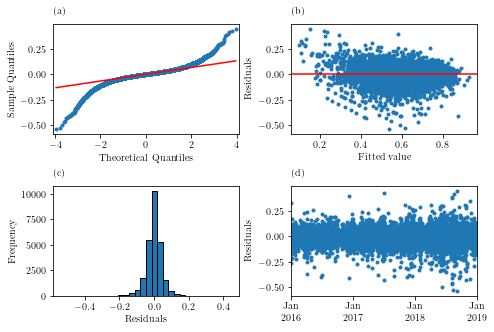

In [31]:
# PM10
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True, figsize = (6.75, 4.5))

# QQ-plot of studentized residuals
sm.qqplot(lmod.resid, line='q', ax=ax1, marker=".")
ax1.annotate('(a)', xy=(0, 1.09), xycoords="axes fraction")

# fitted vs residuals
ax2.scatter(lmod.fittedvalues, lmod.resid, marker=".")#, facecolors='none', edgecolors='#1f77b4')
ax2.axhline(0, color='r')
ax2.set_xlabel('Fitted value')
ax2.set_ylabel('Residuals')
ax2.annotate('(b)', xy=(0, 1.09), xycoords="axes fraction")

ax3.hist(lmod.resid, edgecolor='black', bins=30)
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.annotate('(c)', xy=(0, 1.09), xycoords="axes fraction")

lmod.resid.plot(linestyle="", marker='.', ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('Residuals')
ax4.annotate('(d)', xy=(0, 1.09), xycoords="axes fraction")
ax4.set_xticks([], minor=True)
plt.rc('xtick', labelsize=8)

# plt.savefig('../plots/Residual_plots_MLR_PM10.pdf')

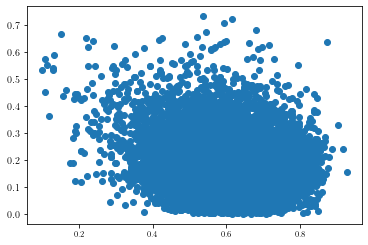

In [32]:
plt.scatter(lmod.fittedvalues, np.sqrt(abs(lmod.resid)))

In [33]:
ddf = pd.DataFrame({'x':lmod.fittedvalues, 'y':np.sqrt((abs(lmod.resid)))})
dmod = smf.ols('y~x', ddf).fit()
dmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     923.9
Date:                Fri, 19 Aug 2022   Prob (F-statistic):          1.76e-199
Time:                        20:58:49   Log-Likelihood:                 27906.
No. Observations:               26305   AIC:                        -5.581e+04
Df Residuals:                   26303   BIC:                        -5.579e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2735      0.004     72.919      0.000       0.266       0.281
x             -0.1850      0.006    -30.396      0.000      -0.197      -0.173
==============================================================================
Omnibus:                     4029.860   Durbin-Watson:                   1.414
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8011.781
Skew:                           0.945   Prob(JB):                         0.00
Kurtosis:                       4.934   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# dfs for new predictions
y_test = df_PM10_test['PM$_{10}$, Stockholm Torkel Knutssonsgatan'] 
X_test = df_PM10_test[stations]

In [ ]:
# log transform test data (but keep the target y in original scale)
# X_test = np.log(X_test) 

In [ ]:
# normalize X and y 
X_test = scaler1.transform(X_test)
X_test = pd.DataFrame(X_test, columns=stations)
X_test.insert(0, 'date', index_test)
X_test.set_index('date', inplace=True)

In [ ]:
X_test.insert(0, 'intercept', 1) # insert column of ones in test data

In [ ]:
# if temporal signals are to be included
X_test = X_test.merge(df_weather_test.iloc[:,s], on='date')

# if weather parameters are to be included
df_weather_test = df_weather_test.iloc[:, w]
df_weather_norm_test = (df_weather_test-df_weather_test.min())/(df_weather_test.max()-df_weather_test.min())
X_test = X_test.merge(df_weather_norm_test, on='date')

In [ ]:
# check if columns in train and test matrices are same
(X_test.columns == X_train.columns).all()

In [ ]:
# if not normalized
# y_pred_frame = np.exp(lmod.get_prediction(X_test).summary_frame()) # for confidence intervals
# y_pred = np.exp(lmod.predict(X_test))

# if normalized
# y_pred = pd.DataFrame(np.exp(scaler2.inverse_transform(lmod.predict(X_test).to_frame())), columns=['PM$_{10}$, predictions'])
y_pred = pd.DataFrame(scaler2.inverse_transform(lmod.predict(X_test).to_frame()), columns=['PM$_{10}$, predictions'])
y_pred.insert(0, 'date', index_test)
y_pred.set_index('date', inplace=True)

In [ ]:
# metrics
print('RMSE:')
# print(np.sqrt(mean_squared_error(y_pred_frame['mean'], y_test)).round(4))
print(np.sqrt(mean_squared_error(y_pred, y_test)).round(5))

print('\nMAPE:')
# print(mean_absolute_percentage_error(y_pred_frame['mean'], y_test).round(4))
print(mean_absolute_percentage_error(y_pred, y_test).round(4))

# Ridge regression

In [ ]:
# X_train_ridge = X_train.drop(columns='intercept', axis=1)
# y_train_ridge = y_train[:]
# X_test_ridge = X_test.drop(columns='intercept', axis=1)

# # X_train_ridge = np.exp(X_train.drop(columns='intercept', axis=1))
# # y_train_ridge = np.exp(y_train[:])
# # X_test_ridge = np.exp(X_test.drop(columns='intercept', axis=1))

# y_test_ridge = y_test[:]

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler1 = MinMaxScaler()
# scaler2 = MinMaxScaler()

# X_train_ridge_scaled = scaler1.fit_transform(X_train_ridge)
# y_train_ridge_scaled = scaler2.fit_transform(y_train_ridge)
# X_test_ridge_scaled = scaler1.transform(X_test_ridge)

In [ ]:
# from itertools import chain
# from sklearn import linear_model
# from sklearn.model_selection import GridSearchCV

# n_alphas = 250
# alphas = np.logspace(-3, 5, n_alphas)
# coefs = []
# for a in alphas:
#     ridge = linear_model.Ridge(alpha=a)
#     ridge.fit(X_train, y_train)
#     coefs.append(list(chain(*ridge.coef_)))
#     # coefs.append(ridge.coef_)

# # select value of alpha with cross-validation
# pars = {'alpha':np.logspace(-3, 5, n_alphas)}
# rr = GridSearchCV(linear_model.Ridge(), pars, scoring='r2', cv=10)
# rr.fit(X_train, y_train)
# bestalpha = rr.best_params_['alpha']

# fig, ax = plt.subplots(figsize=(6, 10), tight_layout=True)
# # ridge trace plot
# ax = plt.gca()
# ax.plot(alphas, coefs)
# ax.set_xscale('log')
# ax.set_xlim(ax.get_xlim()[::-1])
# for i in range(len(X_train.columns)):
#     ax.text(min(alphas)/3.25, coefs[0][i], X_train.columns[i], fontsize=8)
# ax.axvline(bestalpha, color='k', linestyle='--', linewidth=1, alpha=.75)
# ax.set_xlabel(r'$\lambda$')
# ax.set_ylabel('Coefficients')
# plt.savefig('../plots/ridge_trace_plot_PM10.pdf')

In [ ]:
# # new predictions with ridge regression
# rrbest = linear_model.Ridge(alpha=bestalpha, fit_intercept=True)
# rrbest.fit(X_train, y_train)

# print('RMSE:') 
# # print(np.sqrt(mean_squared_error(np.exp(scaler2.inverse_transform(rrbest.predict(X_test))), y_test)).round(5))
# print(np.sqrt(mean_squared_error(scaler2.inverse_transform(rrbest.predict(X_test)), y_test)).round(5))


# print('\nMAPE:')
# # print(mean_absolute_percentage_error(np.exp(scaler2.inverse_transform(rrbest.predict(X_test))), y_test).round(5))
# print(mean_absolute_percentage_error(scaler2.inverse_transform(rrbest.predict(X_test)), y_test).round(5))

# Robust regression

In [ ]:
rlmod = sm.RLM(y_train, X_train).fit()
print(rlmod.summary())

In [ ]:
# y_pred_robust = pd.DataFrame(np.exp(scaler2.inverse_transform(rlmod.predict(X_test).to_frame())), columns = ['PM$_{10}$, predictions'])
y_pred_robust = pd.DataFrame(scaler2.inverse_transform(rlmod.predict(X_test).to_frame()), columns = ['PM$_{10}$, predictions'])

y_pred_robust.insert(0, 'date', index_test)
y_pred_robust.set_index('date', inplace=True)

In [ ]:
# metrics
print('RMSE:')
# print(np.sqrt(mean_squared_error(y_pred_frame['mean'], y_test)).round(4))
print(np.sqrt(mean_squared_error(y_pred_robust, y_test)).round(4))

print('\nMAPE:')
# print(mean_absolute_percentage_error(y_pred_frame['mean'], y_test).round(4))
print(mean_absolute_percentage_error(y_pred_robust, y_test).round(4))